## Reproducible Deep Learning (PhD course, Data Science)
### Extra: Global Explainability for Feature Importance Using SAGE

A well trained NN is able to deliver good predictive performances. However, in certain fields we are interested to know which are the input features that mostly contribute to the output prediction. There are two approaches to explainability:

* Local: given an input instance, we measure the impact on the output of the features for that very instance.
* Global: we measure the overall impact (dataset-wise) of the features on the model performances.

The latter is the goal of SAGE, that we will use in this notebook.
Explaining a prediction can be fundamentl in order to both prodive meaningful insights on what the net learned and also for debugging and inspection purposes. 

The original paper can be found here: https://arxiv.org/abs/2004.00668.
The realted github repo is here: https://github.com/iancovert/sage/

**Setup the machine**:
1. Follow the instructions from here: https://github.com/sscardapane/reprodl2021#local-set-up
2. Download the Carifornia Housing Prices dataset inside a 'data' folder from here: https://www.kaggle.com/camnugent/california-housing-prices. Alternatively, one can use Kaggle API: kaggle datasets download -d camnugent/california-housing-prices

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [4]:
torch.cuda.is_available()

True

### Step 1:Loading Data and EDA

We load our dataset and do some basic exploratory data analysis. We use a simple dataset such as the Califorina Housing Prices since it is straighforward to intepret the featuers, and it will be easier for our explainability phase. Of course, more complex and interesting dataset can be used.

In [5]:
# Substitute this with your actual path.
datapath = Path('data')

In [6]:
datapath.exists()

True

In [7]:
# Using Path is fundamental to have reproducible code across different operating systems.
df = pd.read_csv(datapath / Path('housing.csv'))

In [8]:
# We need only filename, fold, and target
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We print some info and summary statistics for the dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


There are some NULL values for total_bedrooms. One possible solution is to substitute the null values with the avg value.

In [11]:
mean_values = df.mean(axis = 0, skipna = True)
display(mean_values.head())

for feature in df.columns[:-1]:
    df[feature].replace(to_replace=np.nan , value = mean_values[feature], inplace = True)

display(df.info())

C:\Users\Andrea\AppData\Local\Temp/ipykernel_1544/4190552582.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_values = df.mean(axis = 0, skipna = True)


longitude             -119.569704
latitude                35.631861
housing_median_age      28.639486
total_rooms           2635.763081
total_bedrooms         537.870553
dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

ocean_proximity is ca categorical variable. We transform the categories to int values.

In [12]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

df['ocean_proximity'] = df['ocean_proximity'].cat.codes

In [13]:
#df['ocean_proximity'].value_counts()

In [14]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


Our data can now be used. Of couse there may be many more data processing steps (feature engiennring, outliers removal and so on) but those are not the focus or this notebook (we recall we focus on explainability).

### Step 2: Data Preparation

In [15]:
yData = df.pop("median_house_value").values
xData = df.values

num_features = xData.shape[1]

We scale the data using RobustScaler

In [16]:
transformer = RobustScaler().fit(xData)
transformer_y = RobustScaler().fit(yData.reshape(-1, 1))

xData = transformer.transform(xData)
yData = transformer_y.transform(yData.reshape(-1, 1))

Once the data are properly scaled, we split into train, validation and test sets, setting a seed for reproducible results.

In [17]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size=1 - train_ratio, random_state = 42, shuffle = True)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 42, shuffle = False)

Xtrain = torch.from_numpy(X_train).float()
Xval = torch.from_numpy(X_val).float()
Xtest = torch.from_numpy(X_test).float()
ytrain = torch.from_numpy(y_train).float()
ytest = torch.from_numpy(y_test).float()
yval = torch.from_numpy(y_val).float()


We define DataLoaders for our sets.

In [18]:
train_data = torch.utils.data.TensorDataset(Xtrain, ytrain)
val_data = torch.utils.data.TensorDataset(Xval, yval) 
test_data = torch.utils.data.TensorDataset(Xtest, ytest) 


train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=64)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Step 3: Building the Model

We use Pytorch Lightning to define our model. For our purpose, a MLP is enough. 

In [19]:
class MLP(pl.LightningModule):
    
    def __init__(self, num_feat, dropout_prob = 0.3, learning_rate = 1e-4):
        super().__init__()
        self.lr = learning_rate
        self.fc1 = nn.Linear(num_feat, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.drop = nn.Dropout(p = dropout_prob)
        self.out = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.out(self.drop(x))
        
        return x
    
    def training_step(self, batch, batch_idx):
        # Very simple training loop
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, on_step=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        err = F.mse_loss(y_hat, y)
        self.log('val_loss', err, on_epoch=True, prog_bar=True)
        return err
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        err = F.mse_loss(y_hat, y)
        self.log('val_loss', err, on_epoch=True, prog_bar=True)
        return err
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

We set a global seed

In [20]:
pl.seed_everything(42)

Global seed set to 42


42

## Training and Testing

In [21]:
# Test that the network works on a single mini-batch
net = MLP(num_feat = num_features)
xb, yb = next(iter(train_data_loader))
net(xb).shape

torch.Size([64, 1])

In [22]:
trainer = pl.Trainer(gpus=1, max_epochs=25, deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [23]:
trainer.fit(net, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | fc1  | Linear  | 1.3 K 
1 | fc2  | Linear  | 8.3 K 
2 | fc3  | Linear  | 2.1 K 
3 | drop | Dropout | 0     
4 | out  | Linear  | 33    
---------------------------------
11.6 K    Trainable params
0         Non-trainable params
11.6 K    Total params
0.047     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\Andrea\anaconda3\envs\reprodl\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
C:\Users\Andrea\anaconda3\envs\reprodl\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [24]:
trainer.test(net, test_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Andrea\anaconda3\envs\reprodl\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'val_loss': 0.15810918807983398}
--------------------------------------------------------------------------------


[{'val_loss': 0.15810918807983398}]

<!-- ### Step 3: Building the Model -->

## Global Intepretability with SAGE 

### Individual Feature Importance

In [25]:
import sage

In [26]:
# Setup and calculate
imputer = sage.MarginalImputer(net, X_test[:512])


Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


In [27]:
estimator = sage.PermutationEstimator(imputer, 'mse')
pred = net(Xtest)

In [28]:
#TODO: fix
sage_values = estimator(X_test, y_test)

  0%|          | 0/1 [00:00<?, ?it/s]

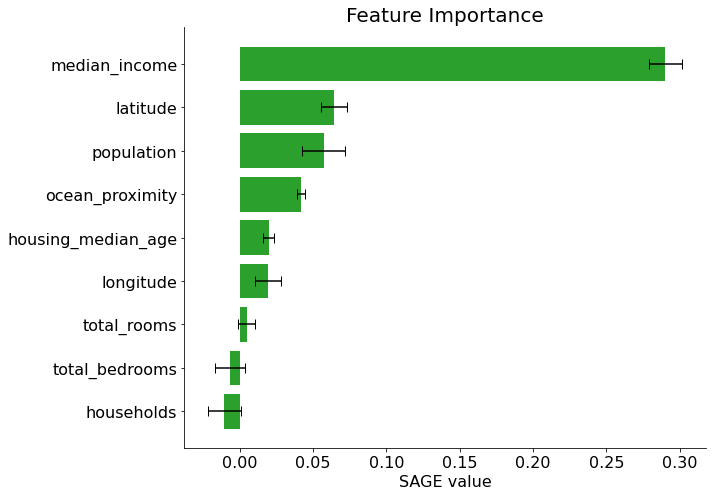

In [30]:
feature_names = list(df.columns) #in the same order they appear in the data
sage_values.plot(feature_names)

### Gropued Feature importance
Sage give the possibility gruop feature in order to study their overall joint effect on the model prediction.

In [49]:
# we create feature groups we may be interested in
feature_groups = group_names = {
    'location (grouped)': ['longitude', 'latitude', 'ocean_proximity'],
    'rooms (grouped)': ['total_rooms', 'total_bedrooms'],
    'people density (grouped)': ['population', 'households'],
    'median_income': ['median_income'],
    'housing_median_age': ['housing_median_age']
}

group_names = list(feature_groups.keys())

In [50]:
# Group indices
groups = []
for _, group in feature_groups.items():
    ind_list = []
    for feature in group:
        ind_list.append(feature_names.index(feature))
    groups.append(ind_list)

In [52]:
imputer = sage.GroupedMarginalImputer(net, X_test[:512], groups)
estimator = sage.PermutationEstimator(imputer, 'mse')
sage_values = estimator(X_test, y_test)

Setting up imputer for PyTorch model, assuming that any necessary output activations are applied properly. If not, please set up nn.Sequential with nn.Sigmoid or nn.Softmax


  0%|          | 0/1 [00:00<?, ?it/s]

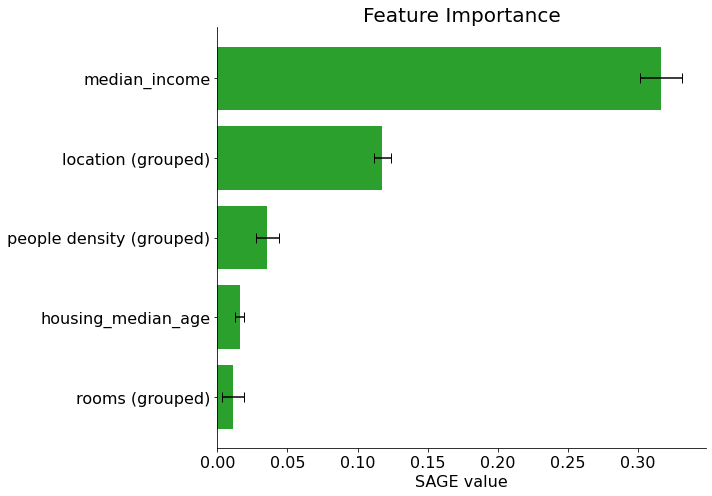

In [53]:
sage_values.plot(group_names)